In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = Y - 0.5
            
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
#train_ids = all_ids[:8000]
#val_ids   = all_ids[8000:]#1000]

train_ids = all_ids[:800]
val_ids   = all_ids[800:1000]#1000]

params = {
    'batch_size'  : 8,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [4]:
def train_one_epoch(
    model,
    optimizer,
    loss_fn
):
    running_loss = 0.
    #loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer,
    loss_fn
):
    running_loss = 0.
    #loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output
model = Network()
no_of_params(model)

74405

In [21]:
lr = 1e-7
wd = 1e-3
model = Network()

epochs = 500
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

scheduler = lr_scheduler.CyclicLR(
    optimizer,
    base_lr=3e-8,
    max_lr=3e-7,
    cycle_momentum=False,
    gamma=1,
    step_size_up=10,
    step_size_down =10,
    mode='triangular2',
)

train_losses = []
val_losses   = []
lrs          = []

loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()

for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer,loss_fn)
    val_loss   = validate_one_epoch(model,optimizer,loss_fn)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

# txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
# plt.title(txt)
# plt.plot(train_losses)
# plt.plot(val_losses)
# plt.show()

# for batch in validation_generator:
#     break
# output = model(batch[0])
# output
# plt.title(txt)
# plt.plot(output.detach().numpy()*3.1415926)
# plt.plot(batch[1].detach().numpy()*3.1415926)
# plt.show()

EPOCH:  1  Train loss:  0.1064  Val loss:  0.0972  LR:  5.7e-08
EPOCH:  2  Train loss:  0.0944  Val loss:  0.0846  LR:  8.4e-08
EPOCH:  3  Train loss:  0.076  Val loss:  0.0634  LR:  1.11e-07
EPOCH:  4  Train loss:  0.0578  Val loss:  0.0466  LR:  1.38e-07
EPOCH:  5  Train loss:  0.0407  Val loss:  0.0327  LR:  1.65e-07
EPOCH:  6  Train loss:  0.0305  Val loss:  0.0244  LR:  1.92e-07
EPOCH:  7  Train loss:  0.0268  Val loss:  0.023  LR:  2.19e-07
EPOCH:  8  Train loss:  0.0283  Val loss:  0.0276  LR:  2.46e-07
EPOCH:  9  Train loss:  0.0328  Val loss:  0.0301  LR:  2.73e-07
EPOCH:  10  Train loss:  0.0379  Val loss:  0.0353  LR:  3e-07
EPOCH:  11  Train loss:  0.0438  Val loss:  0.0433  LR:  2.73e-07
EPOCH:  12  Train loss:  0.0517  Val loss:  0.0488  LR:  2.46e-07
EPOCH:  13  Train loss:  0.0606  Val loss:  0.0562  LR:  2.19e-07
EPOCH:  14  Train loss:  0.0691  Val loss:  0.0623  LR:  1.92e-07
EPOCH:  15  Train loss:  0.0752  Val loss:  0.0656  LR:  1.65e-07
EPOCH:  16  Train loss:  0

EPOCH:  126  Train loss:  0.0074  Val loss:  0.0068  LR:  3.25e-08
EPOCH:  127  Train loss:  0.0071  Val loss:  0.0067  LR:  3.3e-08
EPOCH:  128  Train loss:  0.007  Val loss:  0.0065  LR:  3.34e-08
EPOCH:  129  Train loss:  0.0067  Val loss:  0.0063  LR:  3.38e-08
EPOCH:  130  Train loss:  0.0067  Val loss:  0.0062  LR:  3.42e-08
EPOCH:  131  Train loss:  0.0065  Val loss:  0.0059  LR:  3.38e-08
EPOCH:  132  Train loss:  0.0062  Val loss:  0.0058  LR:  3.34e-08
EPOCH:  133  Train loss:  0.0063  Val loss:  0.0056  LR:  3.3e-08
EPOCH:  134  Train loss:  0.0059  Val loss:  0.0055  LR:  3.25e-08
EPOCH:  135  Train loss:  0.0057  Val loss:  0.0053  LR:  3.21e-08
EPOCH:  136  Train loss:  0.0057  Val loss:  0.0052  LR:  3.17e-08
EPOCH:  137  Train loss:  0.0056  Val loss:  0.005  LR:  3.13e-08
EPOCH:  138  Train loss:  0.0053  Val loss:  0.0049  LR:  3.08e-08
EPOCH:  139  Train loss:  0.0053  Val loss:  0.0048  LR:  3.04e-08
EPOCH:  140  Train loss:  0.0052  Val loss:  0.0047  LR:  3e-08
EP

EPOCH:  250  Train loss:  0.0023  Val loss:  0.0024  LR:  3.01e-08
EPOCH:  251  Train loss:  0.0022  Val loss:  0.0024  LR:  3.01e-08
EPOCH:  252  Train loss:  0.0024  Val loss:  0.0024  LR:  3.01e-08
EPOCH:  253  Train loss:  0.0022  Val loss:  0.0024  LR:  3e-08
EPOCH:  254  Train loss:  0.0022  Val loss:  0.0024  LR:  3e-08
EPOCH:  255  Train loss:  0.0022  Val loss:  0.0024  LR:  3e-08
EPOCH:  256  Train loss:  0.0022  Val loss:  0.0024  LR:  3e-08
EPOCH:  257  Train loss:  0.0022  Val loss:  0.0024  LR:  3e-08
EPOCH:  258  Train loss:  0.0022  Val loss:  0.0023  LR:  3e-08
EPOCH:  259  Train loss:  0.0022  Val loss:  0.0023  LR:  3e-08
EPOCH:  260  Train loss:  0.0022  Val loss:  0.0023  LR:  3e-08
EPOCH:  261  Train loss:  0.0022  Val loss:  0.0023  LR:  3e-08
EPOCH:  262  Train loss:  0.0022  Val loss:  0.0023  LR:  3e-08
EPOCH:  263  Train loss:  0.0021  Val loss:  0.0023  LR:  3e-08
EPOCH:  264  Train loss:  0.0022  Val loss:  0.0023  LR:  3e-08
EPOCH:  265  Train loss:  0.002

EPOCH:  379  Train loss:  0.0011  Val loss:  0.001  LR:  3e-08
EPOCH:  380  Train loss:  0.0011  Val loss:  0.001  LR:  3e-08
EPOCH:  381  Train loss:  0.0011  Val loss:  0.001  LR:  3e-08
EPOCH:  382  Train loss:  0.001  Val loss:  0.001  LR:  3e-08
EPOCH:  383  Train loss:  0.001  Val loss:  0.0009  LR:  3e-08
EPOCH:  384  Train loss:  0.0011  Val loss:  0.001  LR:  3e-08
EPOCH:  385  Train loss:  0.001  Val loss:  0.0009  LR:  3e-08
EPOCH:  386  Train loss:  0.001  Val loss:  0.0009  LR:  3e-08
EPOCH:  387  Train loss:  0.001  Val loss:  0.0009  LR:  3e-08
EPOCH:  388  Train loss:  0.001  Val loss:  0.0009  LR:  3e-08
EPOCH:  389  Train loss:  0.001  Val loss:  0.0009  LR:  3e-08
EPOCH:  390  Train loss:  0.0009  Val loss:  0.0009  LR:  3e-08
EPOCH:  391  Train loss:  0.0009  Val loss:  0.0009  LR:  3e-08
EPOCH:  392  Train loss:  0.001  Val loss:  0.0009  LR:  3e-08
EPOCH:  393  Train loss:  0.0009  Val loss:  0.0008  LR:  3e-08
EPOCH:  394  Train loss:  0.0009  Val loss:  0.0008  

# MSE LOSS

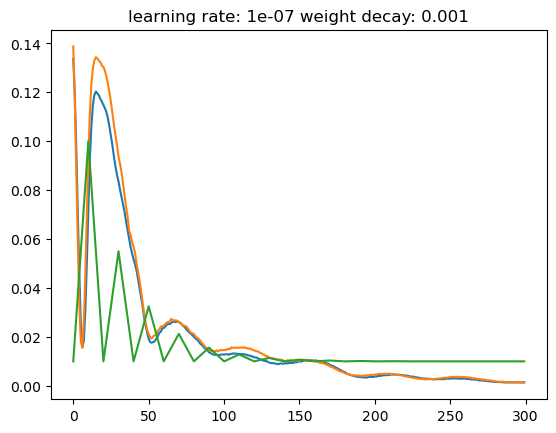

In [10]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/3e-6 for lr in lrs ])
plt.show()

# MAE LOSS

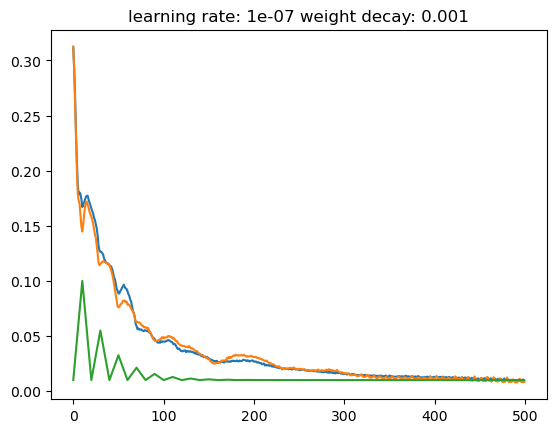

In [15]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/3e-6 for lr in lrs ])
plt.show()

In [20]:
mae_train_losses

[0.3115846201777458,
 0.29317707270383836,
 0.26802008725702764,
 0.2355540657043457,
 0.20942716769874095,
 0.1870873487740755,
 0.17808255463838576,
 0.18018271312117576,
 0.1787101809680462,
 0.1738834910839796,
 0.16694518238306044,
 0.16878426872193814,
 0.17136417187750339,
 0.17371178030967713,
 0.1762617312371731,
 0.1772032856196165,
 0.1771781938150525,
 0.1735651820152998,
 0.17093399688601493,
 0.16872594363987445,
 0.16573996111750602,
 0.16326032280921937,
 0.1611802313476801,
 0.15718770176172256,
 0.15519605584442617,
 0.15140790186822414,
 0.14735789507627486,
 0.14110486734658478,
 0.131700975894928,
 0.12749064724892378,
 0.1263020120561123,
 0.12636933576315643,
 0.12511703986674547,
 0.12411623321473599,
 0.12043468188494444,
 0.11871652506291866,
 0.11669864133000374,
 0.11647813677787781,
 0.11539826937019824,
 0.11554521948099136,
 0.11395922109484673,
 0.11362734977155924,
 0.11300606600940227,
 0.11077565349638462,
 0.10775559972971678,
 0.10359411928802728,
 

1.6429858774417279


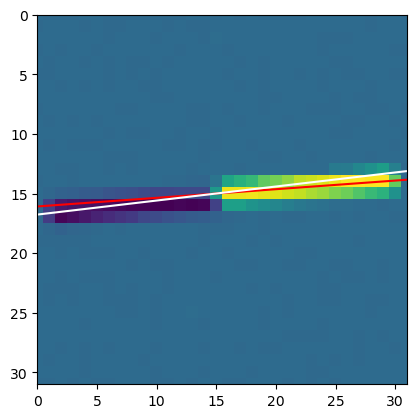

0.05044661789333189


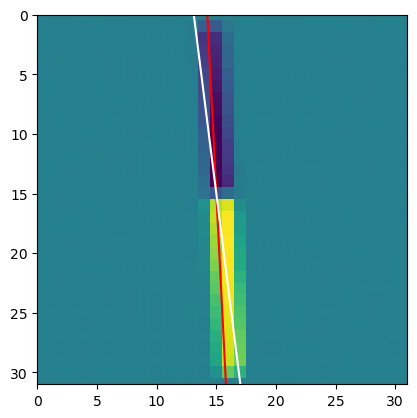

1.2585847413298388


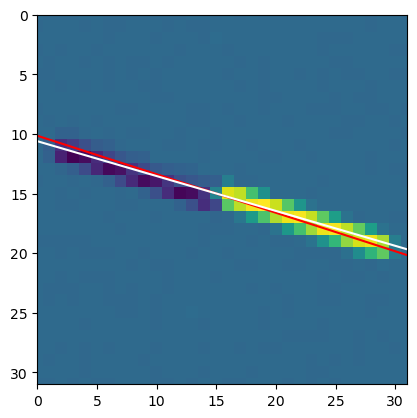

1.8247330063980387


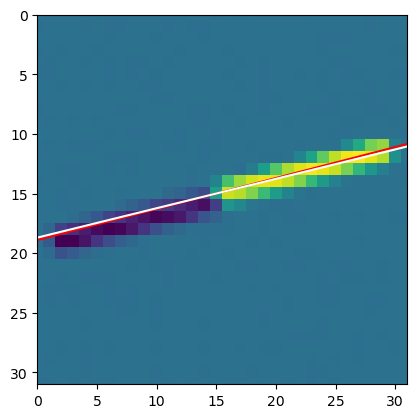

2.359814064562776


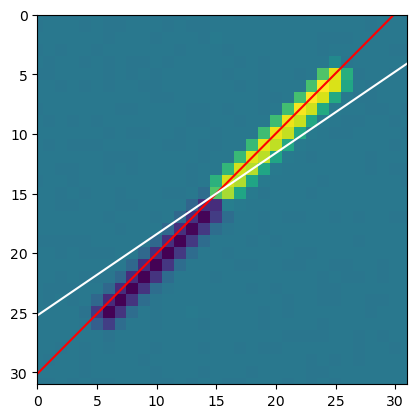

1.2773740729867387


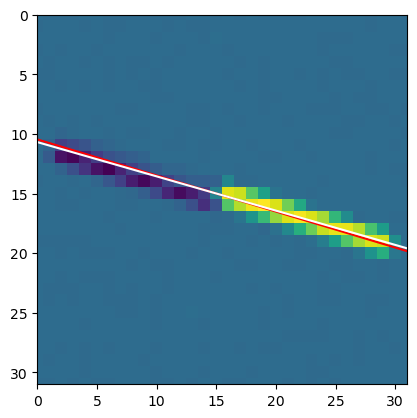

0.8291575703546284


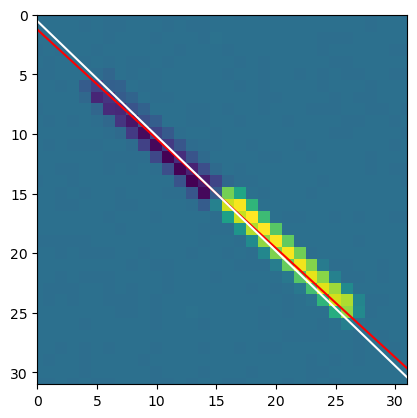

3.0779945816205254


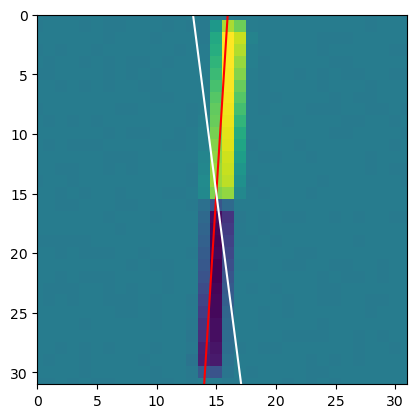

0.30829932428514456


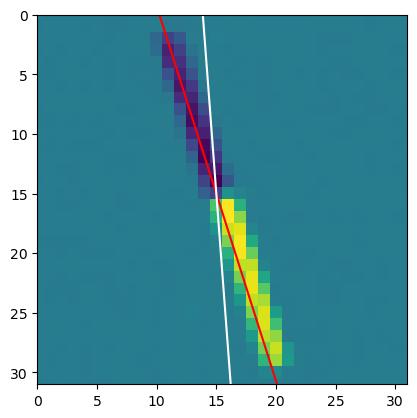

1.9367913628781288


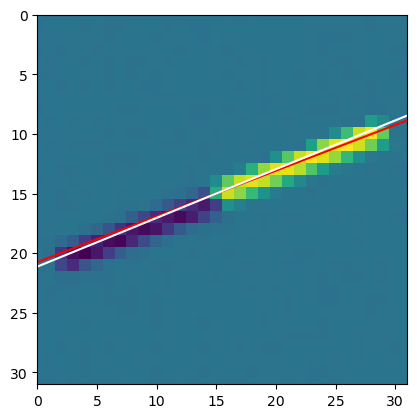

2.726099749437953


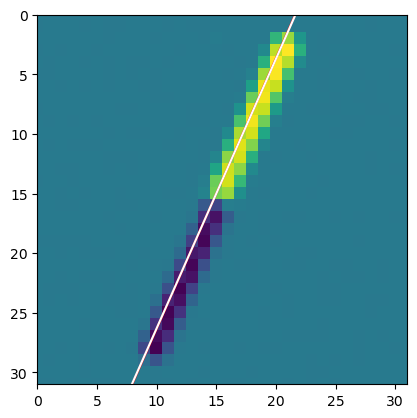

1.8372665329437954


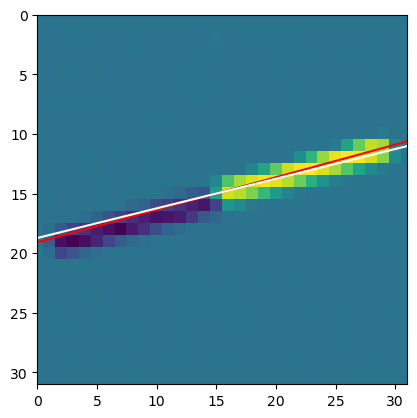

2.8348549209101117


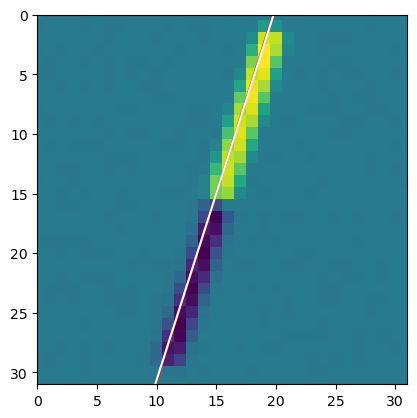

0.1341496349420485


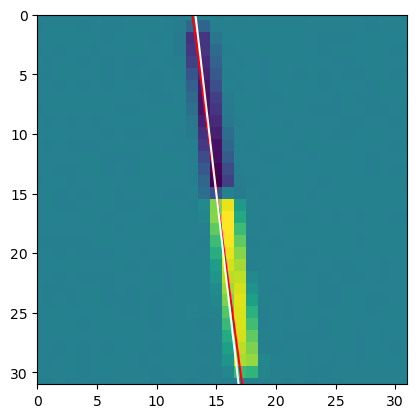

0.5828619774555297


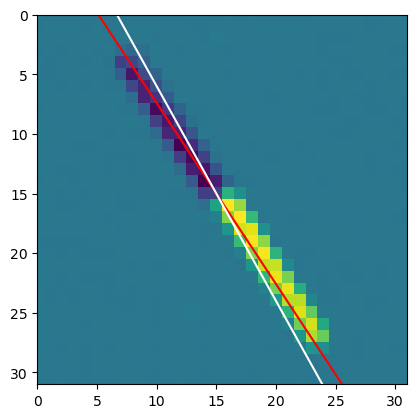

2.5360558036383924


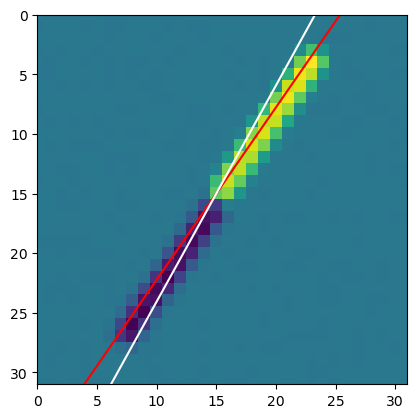

2.5932619261871874


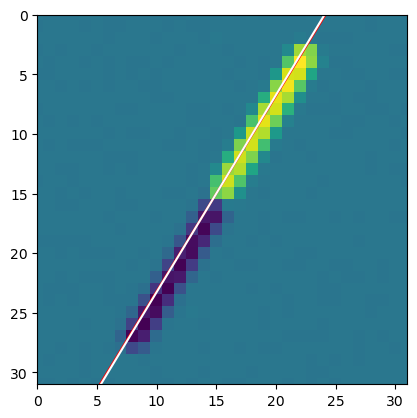

1.8404912969162053


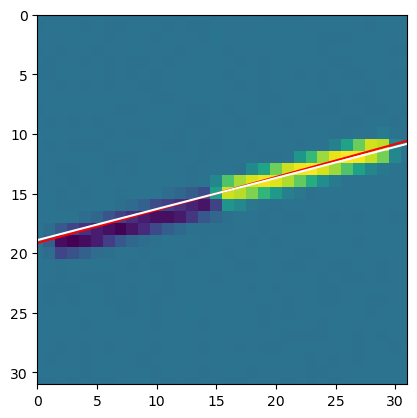

0.6194797188967616


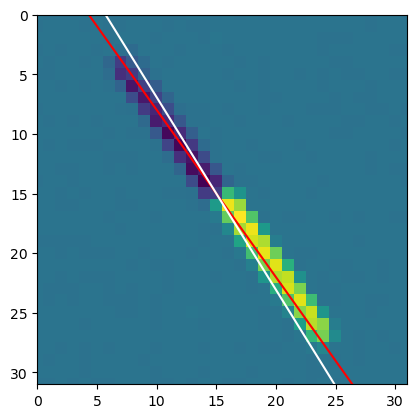

0.05558028115491181


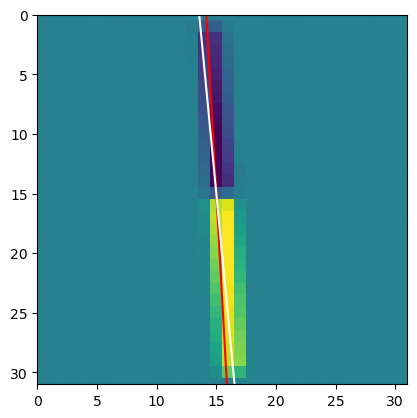

3.0151972661765036


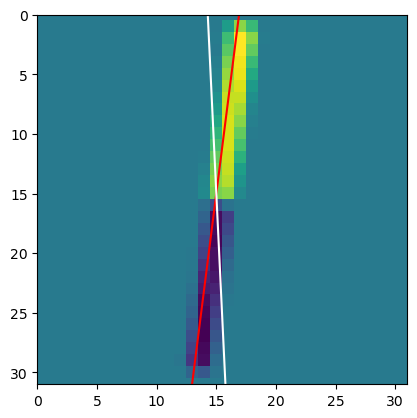

0.023968771431961296


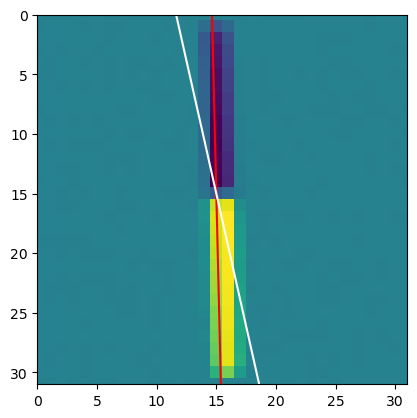

2.218760257336853


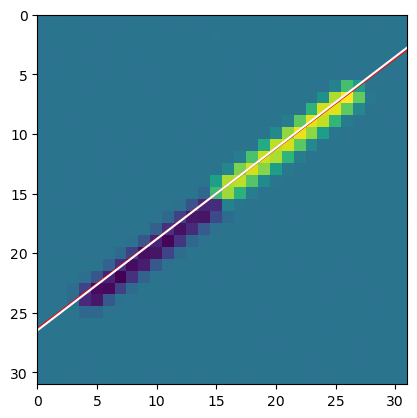

2.7991556409863736


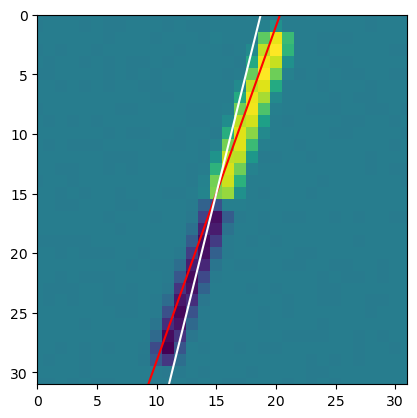

1.7119202719219022


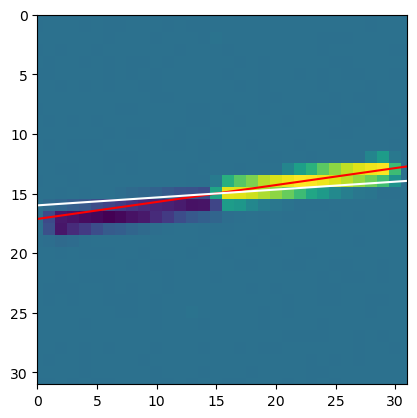

2.681550225181965


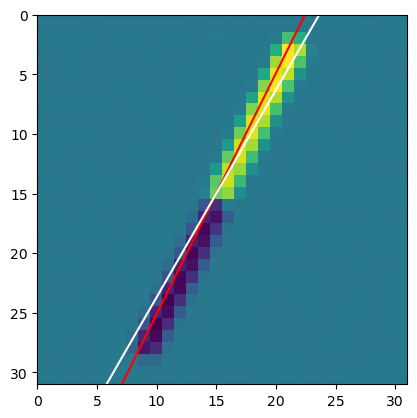

1.8091499922447742


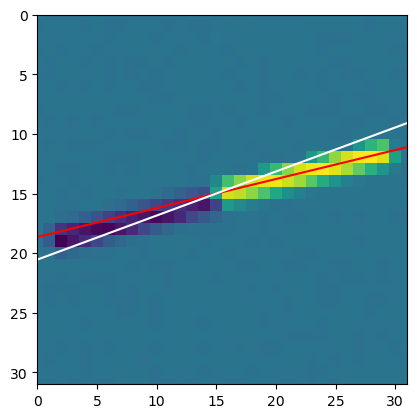

0.8268969708258903


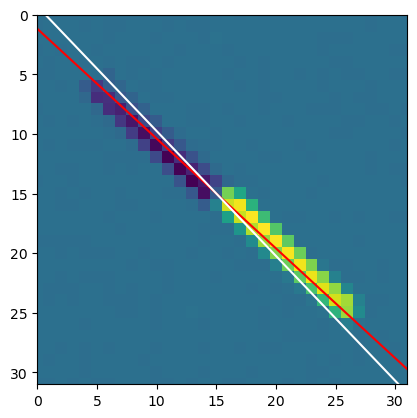

0.6194797188967616


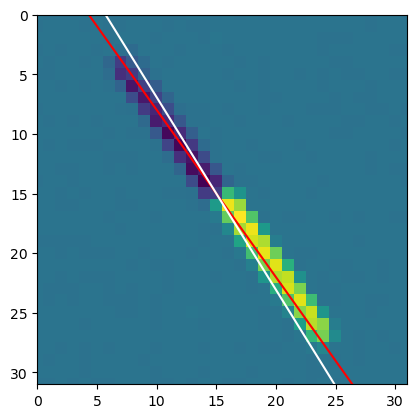

2.6110321858184053


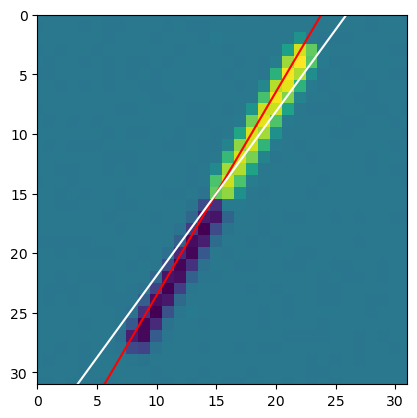

In [11]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    #Y = Y + 0.5
        
    output = (float(model(X[1].unsqueeze(0).unsqueeze(0))) + 0.5 )*3.1415926
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [15 - 50*math.tan(Y),15 ,15 + 50*math.tan(Y)],[15 - 50, 15,15 + 50], c='r')
    plt.plot( [15 - 50*math.tan(output),15 ,15 + 50*math.tan(output)],[15 - 50, 15,15 + 50], c='w')
    
    plt.xlim(0,31)
    plt.ylim(31,0)
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        

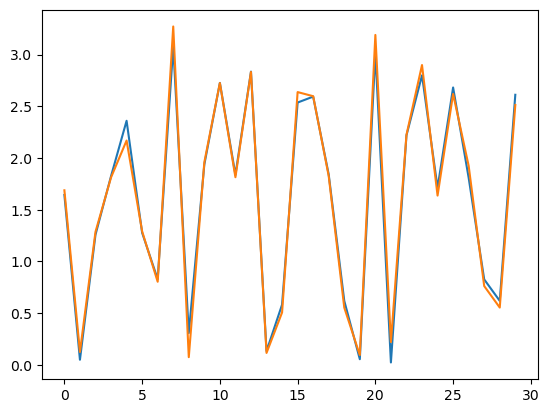

In [12]:
plt.plot(real)
plt.plot(outputs)

# MODIFIED LOSS FUNCTION

In [39]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*10*10, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

torch.set_default_tensor_type(torch.FloatTensor)
model = Network()
no_of_params(model)

74405

In [40]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss = 10.*loss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss = 10.*loss
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [41]:
lr = 1e-7
wd = 1e-3
model = Network()

epochs = 500
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

# scheduler = lr_scheduler.CyclicLR(
#     optimizer,
#     base_lr=1e-8,
#     max_lr=1e-7,
#     cycle_momentum=False,
#     gamma=1,
#     step_size_up=10,
#     step_size_down =10,
#     mode='triangular2',
#)

gamma = 0.995
scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    #step_size = scheduler_step_size, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

# txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
# plt.title(txt)
# plt.plot(train_losses)
# plt.plot(val_losses)
# plt.show()

# for batch in validation_generator:
#     break
# output = model(batch[0])
# output
# plt.title(txt)
# plt.plot(output.detach().numpy()*3.1415926)
# plt.plot(batch[1].detach().numpy()*3.1415926)
# plt.show()

EPOCH:  1  Train loss:  2.3034  Val loss:  2.0254  LR:  9.95e-08
EPOCH:  2  Train loss:  1.9741  Val loss:  1.6826  LR:  9.9e-08
EPOCH:  3  Train loss:  1.6708  Val loss:  1.4042  LR:  9.85e-08
EPOCH:  4  Train loss:  1.39  Val loss:  1.1773  LR:  9.8e-08
EPOCH:  5  Train loss:  1.1504  Val loss:  0.9505  LR:  9.75e-08
EPOCH:  6  Train loss:  0.9375  Val loss:  0.7604  LR:  9.7e-08
EPOCH:  7  Train loss:  0.7629  Val loss:  0.6123  LR:  9.66e-08
EPOCH:  8  Train loss:  0.633  Val loss:  0.4818  LR:  9.61e-08
EPOCH:  9  Train loss:  0.5148  Val loss:  0.3916  LR:  9.56e-08
EPOCH:  10  Train loss:  0.422  Val loss:  0.3136  LR:  9.51e-08
EPOCH:  11  Train loss:  0.3497  Val loss:  0.2665  LR:  9.46e-08
EPOCH:  12  Train loss:  0.3006  Val loss:  0.2212  LR:  9.42e-08
EPOCH:  13  Train loss:  0.2685  Val loss:  0.2089  LR:  9.37e-08
EPOCH:  14  Train loss:  0.2516  Val loss:  0.2161  LR:  9.32e-08
EPOCH:  15  Train loss:  0.2469  Val loss:  0.2013  LR:  9.28e-08
EPOCH:  16  Train loss:  0

EPOCH:  126  Train loss:  0.1317  Val loss:  0.1264  LR:  5.32e-08
EPOCH:  127  Train loss:  0.1317  Val loss:  0.1283  LR:  5.29e-08
EPOCH:  128  Train loss:  0.1293  Val loss:  0.127  LR:  5.26e-08
EPOCH:  129  Train loss:  0.1287  Val loss:  0.1261  LR:  5.24e-08
EPOCH:  130  Train loss:  0.1281  Val loss:  0.1248  LR:  5.21e-08
EPOCH:  131  Train loss:  0.1245  Val loss:  0.1244  LR:  5.19e-08
EPOCH:  132  Train loss:  0.1238  Val loss:  0.1228  LR:  5.16e-08
EPOCH:  133  Train loss:  0.1222  Val loss:  0.1219  LR:  5.13e-08
EPOCH:  134  Train loss:  0.1217  Val loss:  0.1205  LR:  5.11e-08
EPOCH:  135  Train loss:  0.1177  Val loss:  0.12  LR:  5.08e-08
EPOCH:  136  Train loss:  0.1185  Val loss:  0.1176  LR:  5.06e-08
EPOCH:  137  Train loss:  0.1167  Val loss:  0.1154  LR:  5.03e-08
EPOCH:  138  Train loss:  0.1127  Val loss:  0.1137  LR:  5.01e-08
EPOCH:  139  Train loss:  0.1107  Val loss:  0.1122  LR:  4.98e-08
EPOCH:  140  Train loss:  0.1085  Val loss:  0.11  LR:  4.96e-08


EPOCH:  250  Train loss:  0.0313  Val loss:  0.03  LR:  2.86e-08
EPOCH:  251  Train loss:  0.0315  Val loss:  0.0294  LR:  2.84e-08
EPOCH:  252  Train loss:  0.0311  Val loss:  0.0299  LR:  2.83e-08
EPOCH:  253  Train loss:  0.0311  Val loss:  0.0291  LR:  2.81e-08
EPOCH:  254  Train loss:  0.0311  Val loss:  0.03  LR:  2.8e-08
EPOCH:  255  Train loss:  0.0308  Val loss:  0.0289  LR:  2.79e-08
EPOCH:  256  Train loss:  0.0317  Val loss:  0.0295  LR:  2.77e-08
EPOCH:  257  Train loss:  0.0311  Val loss:  0.029  LR:  2.76e-08
EPOCH:  258  Train loss:  0.0314  Val loss:  0.0299  LR:  2.74e-08
EPOCH:  259  Train loss:  0.03  Val loss:  0.0294  LR:  2.73e-08
EPOCH:  260  Train loss:  0.0296  Val loss:  0.0287  LR:  2.72e-08
EPOCH:  261  Train loss:  0.0302  Val loss:  0.0294  LR:  2.7e-08
EPOCH:  262  Train loss:  0.0304  Val loss:  0.0283  LR:  2.69e-08
EPOCH:  263  Train loss:  0.0295  Val loss:  0.0283  LR:  2.68e-08
EPOCH:  264  Train loss:  0.0281  Val loss:  0.0273  LR:  2.66e-08
EPOC

EPOCH:  374  Train loss:  0.0143  Val loss:  0.0144  LR:  1.53e-08
EPOCH:  375  Train loss:  0.0139  Val loss:  0.0144  LR:  1.53e-08
EPOCH:  376  Train loss:  0.0151  Val loss:  0.0142  LR:  1.52e-08
EPOCH:  377  Train loss:  0.0134  Val loss:  0.014  LR:  1.51e-08
EPOCH:  378  Train loss:  0.0144  Val loss:  0.0143  LR:  1.5e-08
EPOCH:  379  Train loss:  0.0134  Val loss:  0.014  LR:  1.5e-08
EPOCH:  380  Train loss:  0.014  Val loss:  0.014  LR:  1.49e-08
EPOCH:  381  Train loss:  0.0136  Val loss:  0.0138  LR:  1.48e-08
EPOCH:  382  Train loss:  0.0133  Val loss:  0.014  LR:  1.47e-08
EPOCH:  383  Train loss:  0.0133  Val loss:  0.0138  LR:  1.47e-08
EPOCH:  384  Train loss:  0.0135  Val loss:  0.0134  LR:  1.46e-08
EPOCH:  385  Train loss:  0.0128  Val loss:  0.0136  LR:  1.45e-08
EPOCH:  386  Train loss:  0.0125  Val loss:  0.0132  LR:  1.44e-08
EPOCH:  387  Train loss:  0.0124  Val loss:  0.0131  LR:  1.44e-08
EPOCH:  388  Train loss:  0.0125  Val loss:  0.0131  LR:  1.43e-08
EP

EPOCH:  498  Train loss:  0.0077  Val loss:  0.0076  LR:  8.2e-09
EPOCH:  499  Train loss:  0.0083  Val loss:  0.0071  LR:  8.2e-09
EPOCH:  500  Train loss:  0.0081  Val loss:  0.0072  LR:  8.2e-09


In [33]:
del model